In [14]:
import gymnasium as gym
import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
from collections import namedtuple
from collections import deque
import matplotlib.pyplot as plt

In [15]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ========
            state_size(int): Dimension of each state
            action_size(int): Dimension of each action
            seed(int): Random seed
            fc1_units(int): Number of nodes in first hidden layer
            fc2_units(int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(8, fc1_units) ## nn.Linear - This transformation is represented by the formula y = xA^T + b "https://docs.kanaries.net/topics/Python/nn-linear"
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 4)
        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
        

In [16]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        
        Params
        ======
            action_size (int): Dimension of each action
            buffer_size (int): Maximum size of buffer
            batch_size (int): Size of each training batch
            seed (int): Random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        state = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        action = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_state = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        
        return state, action, rewards, next_state, dones
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)
        

In [17]:
class Agent:
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size(int): Dimension of each state
            action_size(int): Dimension of each action
            seed(int): Random seed
        """
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=5e-4)
        
        # Replay memort
        self.memory = ReplayBuffer(action_size, int(1e5), 64, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > 1000:
                experiences = self.memory.sample()
                self.learn(experiences, 0.99)
    
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(dim=1)[0].unsqueeze(1)
        # Compute Q target for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, 1e-3)
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target 
        
        Params
        ======
            local_model (Pytorch model): weights will be copied from
            target_model (Pytorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0 - tau)*target_param.data)
        

In [18]:
env = gym.make('LunarLander-v2', render_mode='human')

print('State space:', env.observation_space.shape)
print('Action space:', env.action_space.n)
agent = Agent(state_size=4, action_size=2, seed=0)

State space: (8,)
Action space: 4


Episode 100	Average Score: -331.52
Episode 200	Average Score: -203.84
Episode 300	Average Score: -101.57
Episode 400	Average Score: -18.139
Episode 500	Average Score: -8.190
Episode 600	Average Score: -7.558
Episode 700	Average Score: 1.2250
Episode 800	Average Score: 58.35
Episode 900	Average Score: 82.01
Episode 1000	Average Score: 141.79
Episode 1100	Average Score: 190.28
Episode 1108	Average Score: 200.43
Environment solved in 1008 episodes!	Average Score: 200.43


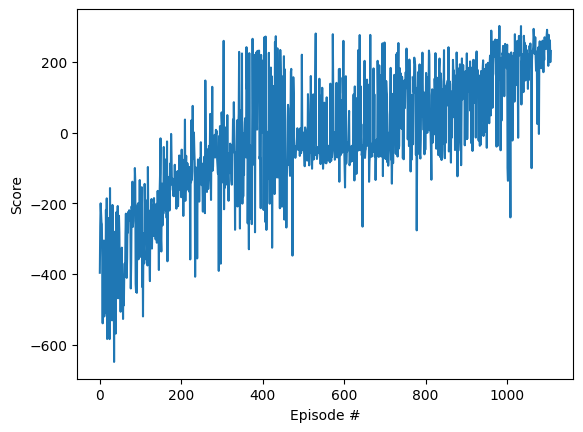

In [19]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state,info = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, info,_ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_car_pole.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [22]:
env = gym.make('LunarLander-v2',render_mode='human')

agent.qnetwork_local.load_state_dict(torch.load('checkpoint_car_pole.pth'))

for i in range(3):
    state,info = env.reset()
    for j in range(400):
        action = agent.act(state)
        env.render()
        state, reward,terminated,truncated,info= env.step(action)
        if terminated or truncated:
            break 
            
env.close()

E:\temp\ipykernel_29940\642839647.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.qnetwork_local.load_state_dict(torch.load('checkpoint_car_pole.pth'))
